In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import pickle
import os
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from src.distance import compute_achilles
import time

from src.data_prep import load_data, split_data
from src.distance import top_n_vulnerable_records
from src.plots import plot_achilles, calculate_statistics, plot_mia_scores
from src.mia import mia

import nest_asyncio
nest_asyncio.apply()

# Load data

In [3]:
path_to_data = 'data/adult/Adult_dataset.csv'
path_to_metadata = 'data/adult/Adult_metadata_discretized.json'

Load the full Adult dataset:

In [4]:
df, categorical_cols, continuous_cols, meta_data = load_data(path_to_data, path_to_metadata)

Split the dataset into auxiliary and evaluation, and get the target dataset from the evaluation pool.

In [5]:
df_aux, df_eval, df_target = split_data(df, 'data/adult/1000_indices.pickle')

# Who are the most vulnerable records?

Find the Achilles score of each record in the target dataset.

In [6]:
t1 = time.time()
all_dists = compute_achilles(df_target, categorical_cols, continuous_cols, meta_data, 5)
t2 = time.time()

print(f'time taken = {(t2-t1)}')


creating tasks


1000it [00:00, 156212.44it/s]


computing achilles


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 481.93it/s]

time taken = 2.0989933013916016


Find the top 10 most vulnerable records:

In [7]:
top_n_records = top_n_vulnerable_records(all_dists, 10)

Let's take a look at the Achilles risk scores of all the records in our target dataset:

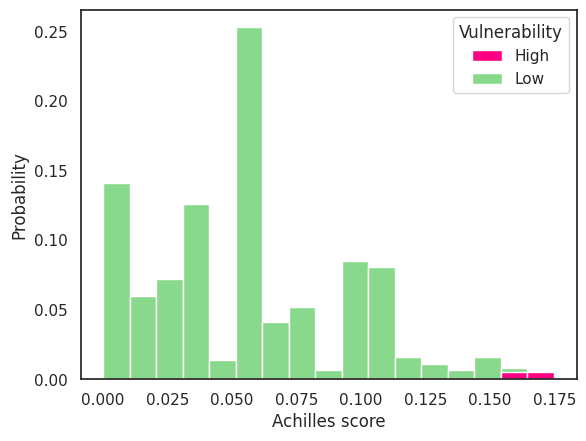

In [8]:
plot_achilles(all_dists, 10)

In [9]:
calculate_statistics(all_dists)

65.50% of the records in the target dataset have a below-average Achilles score.
The third quantile is 0.08, i.e. three quarters (75%) of the records have an Achilles score below 0.08.


The Achilles scores fall in the range between 0.0 and 0.175, with most lying on the lower end or towards the middle of the range. We see from the graph and the descriptive statistics that the risk is likely to lie with only a few high-risk records, with the other records being of low-to-medium risk.

# MIA risk score

Let's now calculate the risk scores using MIAs for the 5 records considererd most vulnerable by their Achilles score. In this notebook, we use 100 shadow and evaluation datasets to save on time, but in a real-life situation, this number should be carefully chosen to ensure stable results and the best possible MIA performance!

In [10]:
from src.mia import mia

mia_results = mia(path_to_data=path_to_data, path_to_metadata=path_to_metadata, path_to_data_split='data/adult/1000_indices.pickle',
                  target_records=top_n_records[:5], generator_name='SYNTHPOP', n_synth=1000, n_datasets=100, epsilon=0.0, output_path='./output/files/')

  0%|                                                                                                                                 | 0/5 [00:00<?, ?it/s]

Generating shadow datasets...
Extracting training features...
training meta-classifier
['random_forest', 'logistic_regression']
Model: random_forest
Model: logistic_regression


 20%|████████████████████████                                                                                                | 1/5 [03:53<15:34, 233.61s/it]

Generating shadow datasets...
Extracting training features...
training meta-classifier
['random_forest', 'logistic_regression']
Model: random_forest
Model: logistic_regression


 40%|████████████████████████████████████████████████                                                                        | 2/5 [07:50<11:47, 235.76s/it]

Generating shadow datasets...
Extracting training features...
training meta-classifier
['random_forest', 'logistic_regression']
Model: random_forest
Model: logistic_regression


 60%|████████████████████████████████████████████████████████████████████████                                                | 3/5 [11:47<07:52, 236.25s/it]

Generating shadow datasets...
Extracting training features...
training meta-classifier
['random_forest', 'logistic_regression']
Model: random_forest
Model: logistic_regression


 80%|████████████████████████████████████████████████████████████████████████████████████████████████                        | 4/5 [15:44<03:56, 236.57s/it]

Generating shadow datasets...
Extracting training features...
training meta-classifier
['random_forest', 'logistic_regression']
Model: random_forest
Model: logistic_regression


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [19:41<00:00, 236.24s/it]


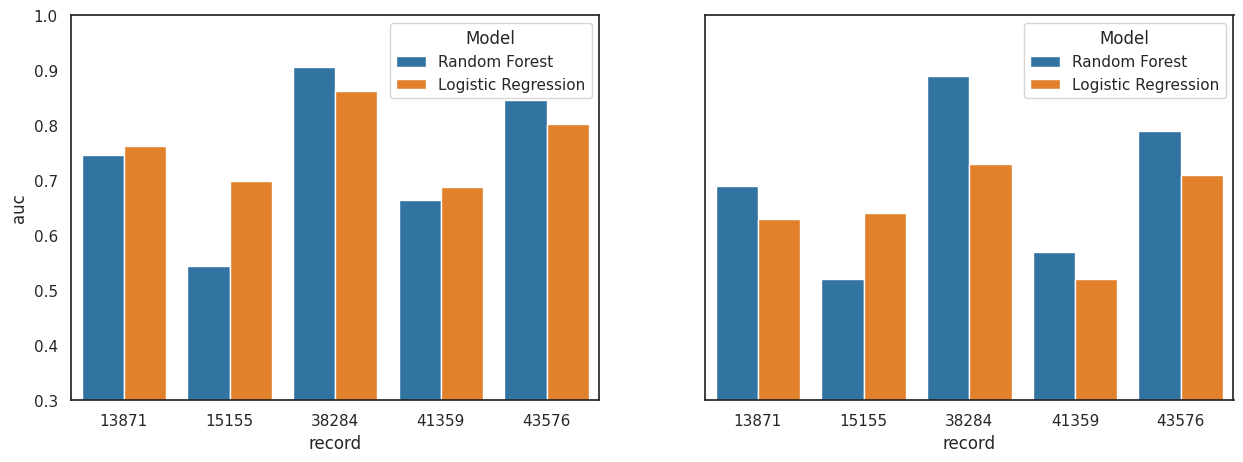

In [11]:
plot_mia_scores(mia_results)